# Rain in Australia
## Table of Contents

Work in progress


## 1. Predict rain tomorrow in Australia

Before we can start with our analysis, we have to check and prepare our data. This is a crucial task and is necessary to prevent data-driven mistakes.

The dataset is hosted by Kaggle: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

Observations were drawn from numerous weather stations. The daily observations are available from http://www.bom.gov.au/climate/data.   
Copyright Commonwealth of Australia 2010, Bureau of Meteorology.

Definitions adapted from http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml

Note: You should exclude the variable Risk-MM when training a binary classification model.   
Not excluding it will leak the answers to your model and reduce its predictability.

### 2. Import libraries

In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### 3. Exploratory data analysis 

In [4]:
data_path = 'data\\weatherAUS.csv'
df = pd.read_csv(data_path, delimiter=",")
df.drop(['RISK_MM'], axis=1, inplace=True)

3.1 __Dimensions and Overview__

In [5]:
print('Shape of the dataset: {}'.format(df.shape))
print('Preview of dataset:')
print(df.head(5))

Shape of the dataset: (142193, 23)
Preview of dataset:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Clou

__Feature types and counts__

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
Date             142193 non-null object
Location         142193 non-null object
MinTemp          141556 non-null float64
MaxTemp          141871 non-null float64
Rainfall         140787 non-null float64
Evaporation      81350 non-null float64
Sunshine         74377 non-null float64
WindGustDir      132863 non-null object
WindGustSpeed    132923 non-null float64
WindDir9am       132180 non-null object
WindDir3pm       138415 non-null object
WindSpeed9am     140845 non-null float64
WindSpeed3pm     139563 non-null float64
Humidity9am      140419 non-null float64
Humidity3pm      138583 non-null float64
Pressure9am      128179 non-null float64
Pressure3pm      128212 non-null float64
Cloud9am         88536 non-null float64
Cloud3pm         85099 non-null float64
Temp9am          141289 non-null float64
Temp3pm          139467 non-null float64
RainToday        140787 non-null obje

As we can see, there are several categorial and numerical features with a count of $81.350$ to $141.193$ entries.   
Furthermore it appears that there are some missing values for almost all features that we have to deal with later on.  
Let's start by ordering the features in two lists.

3.2 __Feature Summary__

In [7]:
cat_feature_list = [var for var in df.columns if df[var].dtype=='O']
num_feature_list = [var for var in df.columns if df[var].dtype=='float64']
print('There are {} categorical and {} numerical variables.\n'.format(len(cat_feature_list), len(num_feature_list)))
print('The categorical features are: \n{}\n'.format(cat_feature_list))
print('The numerical features are: \n{}'.format(num_feature_list))

There are 7 categorical and 16 numerical variables.

The categorical features are: 
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

The numerical features are: 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


First of we should clearify the features, measurements and units.

* __Date__: The date of the observation.
* __Location__: The common name of the location of the weather station.
* __MinTemp__ and __MaxTemp__: Minimum and maximum temperatures on that day in degrees celsius. *
* __Rainfall__: The amount of rainfall recorded for the day in liters per square meters mm.
* __Evaporation__: The so-called Class A pan evaporation (mm) in the 24 hours to 9am.
* __Sunshine__: The number of hours of bright sunshine in the day.
* __WindGustDir__: The direction of the strongest wind gust in the 24 hours to midnight.
* __WindGustSpeed__: The speed (km/h) of the strongest wind gust in the 24 hours to midnight.
* __WindDir9am__ and __WindDir3pm__: Direction of the wind at 9am and 3pm.
* __WindSpeed9am__ and __WindSpeed3pm__: Wind speed (km/h) averaged over 10 minutes prior to 9am and 3pm.
* __Humidity9am__ and __Humidity3pm__: Humidity (percent) at 9am and 3pm.
* __Pressure9am__ and __Pressure3pm__: Atmospheric pressure (hpa) reduced to mean sea level at 9am and 3pm.
* __Cloud9am__ and __Cloud3pm__: Fraction of sky obscured by cloud at 9am. This is measured in "oktas", which are a unit of eigths. It records how many eigths of the sky are obscured by cloud. A 0 measure indicates completely clear sky whilst an 8 indicates that it is completely overcast.
* __Temp9am__ and __Temp3pm__: Temperature at 9am and 3pm in degrees celsius.
* __RainToday__: Boolean: 'Yes' if precipitation (mm) in the 24 hours to 9am exceeds 1mm, otherwise 'No'.
* __RainTomorrow__: The target variable.

*
Comment: This is a bit tricky, because the day goes from 9 am to 9 am for this measurement. This will be further explained later on. 

Now we take a closer look at the possible values for the categorial features.

3.3 __Inspecting categorial features__

In [8]:
cat_summary = [(print(df[cat].unique()), print("\n There are a total of {} unique values for the feature \'{}\'.\n".format(df[cat].nunique(), cat))) for cat in cat_feature_list]

['2008-12-01' '2008-12-02' '2008-12-03' ... '2008-01-29' '2008-01-30'
 '2008-01-31']

 There are a total of 3436 unique values for the feature 'Date'.

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']

 There are a total of 49 unique values for the feature 'Location'.

['W' 'WNW' 'WSW' 'NE' 'NNW' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NW' 'SE' 'ESE'
 nan 'E' 'SSW']

 There are a total of 16 unique values for the feature 'WindGustDir'.

['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S

Ignoring the *nan* values, we can summarize that:  
* __Dates__ are denoted as *YY-MM-DD*. It seems like the record includes 3436 days. Since this is quite a high cardinality,  we should do some preparations to handle it better.
* In __Location__, we have a list of all the locations of 49 weather stations. The data was recorded in Australia.  
* It appears that the same notation is used for the direction of the wind in __WindGustDir__, __WindDir9am__ and __WindDir3pm__. There are a total of $16$ directions with a seperation of $22.5°$ starting from north (N).
* Finally we have two binary features, __RainToday__ and __RainTomorrow__ with the later feature being our target variable for the classification we are about to do.

Luckily, there doesn't seem to be an error or typo here.

3.3.1 __Missing values__

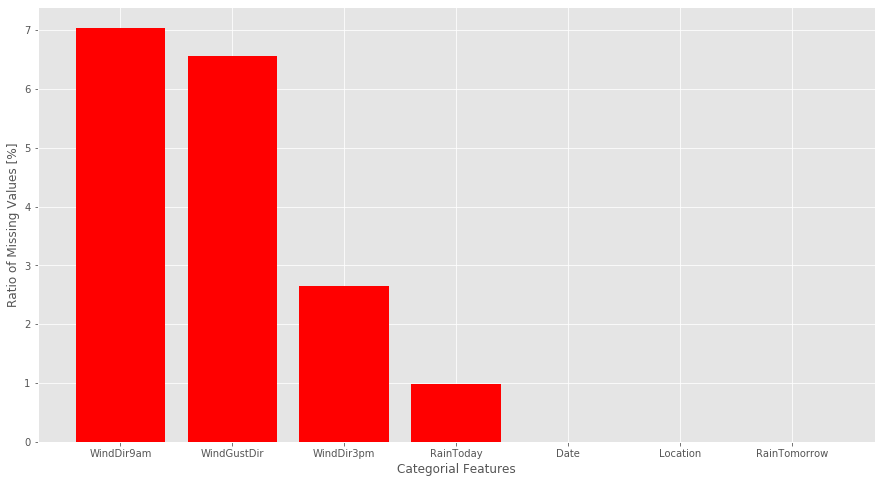


 There are a total of 10013 missing values for the feature 'WindDir9am'.

 There are a total of 9330 missing values for the feature 'WindGustDir'.

 There are a total of 3778 missing values for the feature 'WindDir3pm'.

 There are a total of 1406 missing values for the feature 'RainToday'.

 There are a total of 0 missing values for the feature 'Date'.

 There are a total of 0 missing values for the feature 'Location'.

 There are a total of 0 missing values for the feature 'RainTomorrow'.


In [9]:
cat_missing_value_list = [(cat, (df[cat].isnull().sum()/len(df[cat]))*100) for cat in cat_feature_list]
sorted_list = sorted(cat_missing_value_list, key = lambda x: x[1], reverse=True)
cat_feature_list_sorted, cat_missing_value_list_sorted = zip(*sorted_list)
cat_pos_sorted = [i for i, _ in enumerate(cat_feature_list_sorted)]

plt.figure(figsize=(15,8))
plt.style.use('ggplot')
plt.bar(cat_pos_sorted, cat_missing_value_list_sorted, color='red')
plt.xlabel("Categorial Features")
plt.ylabel("Ratio of Missing Values [%]")
plt.xticks(cat_pos_sorted, cat_feature_list_sorted)
plt.show()

cat_summary = [print("\n There are a total of {} missing values for the feature \'{}\'.".format(df[cat].isnull().sum(), cat)) for cat in cat_feature_list_sorted]

We can note that there are no missing values for the target variable __RainTomorrow__ as well as for __Date__ and __Location__. So we know for every single entry where, when and if it rained the next day.  
With our goal to predict if it will rain in mind, this seems like a good start!

Unfortunately the categorial features __WindDir9am__, __WindGustDir__, __WindDir3pm__ and __RainToday__ do contain missing values but they only make up between $1\,\%$ to $7\,\%$, so I think it's safe to say we should be able to deal with the missing values for the categorial features and don't need to drop any of them because of that. 

3.3.2 __Univariate analysis__

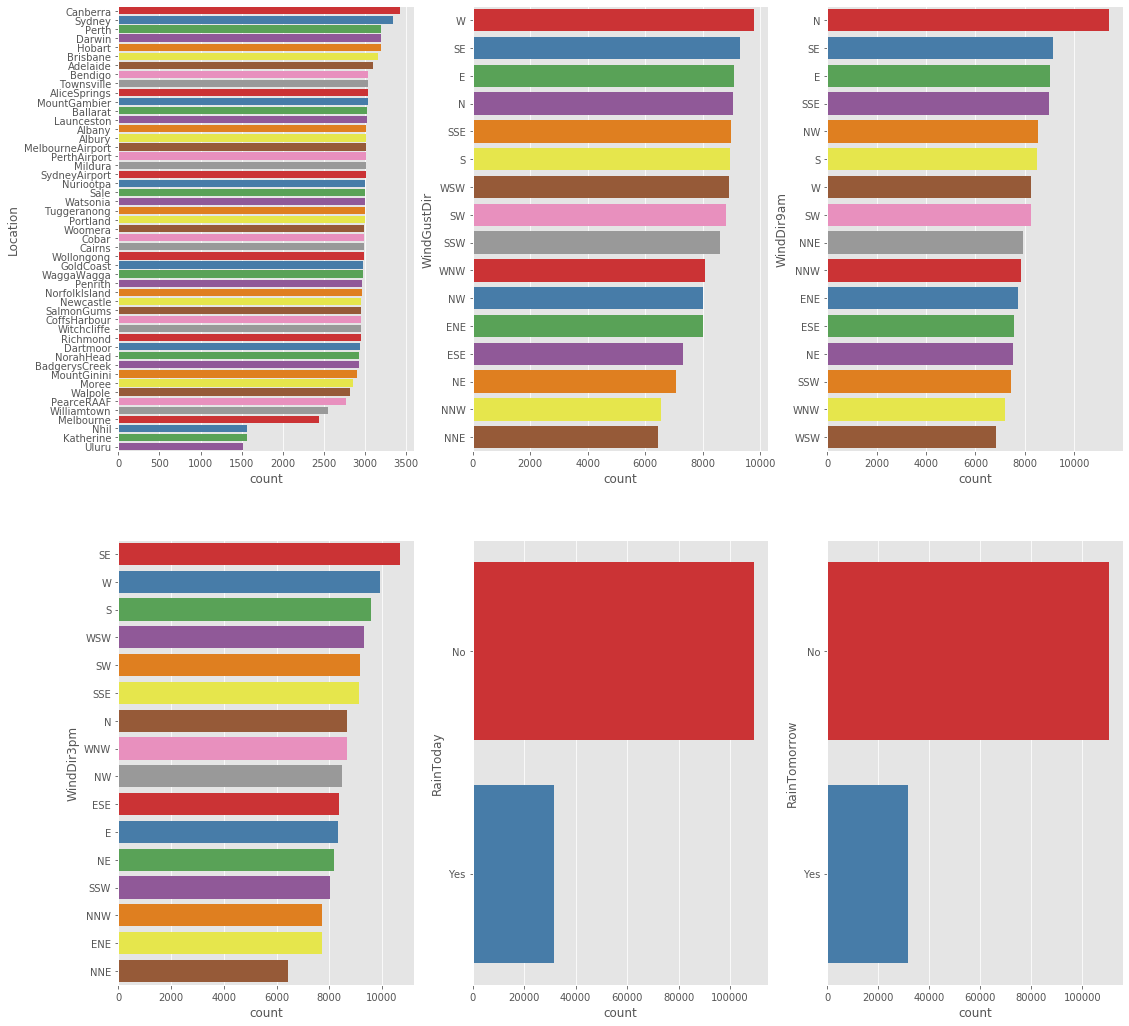

In [10]:
plt.style.use('ggplot')
plt.figure(figsize=(18,18))
for cat_index, cat in enumerate(cat_feature_list):
    if cat == 'Date':
        pass
    else:
        plt.subplot(2, 3, cat_index)
        fig = sns.countplot(y=cat, data=df, order = df[cat].value_counts().index, palette="Set1")

The plots show that the categorial feature __RainToday__ and the target feature __RainTomorrow__ have an imbalanced distrubtion. We can use the ratio of the counts for the two classes in __RainTomorrow__ as our base model accuracy.

As for the other features, the highest and lowest count of the values are within of a factor of about $2$. Also every single value has entries in the order of 1000.


We will need to do some encoding to handle the categorial features, as expected.

__Target Feature__

Here we will quickly compute the ratio of the number of entries per class for the target feature __RainTomorrow__. This will act as our baseline accuracy which we want our models to beat (at least!).

In [20]:
print(df['RainTomorrow'].value_counts()/len(df['RainTomorrow']))

No     0.775819
Yes    0.224181
Name: RainTomorrow, dtype: float64


So our baseline accuracy is about $77.6\,\%$.

3.4 __Inspecting numerical features__

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,141556.0,12.186400,6.403283,-8.5,7.6,12.0,16.8,33.9
MaxTemp,141871.0,23.226784,7.117618,-4.8,17.9,22.6,28.2,48.1
Rainfall,140787.0,2.349974,8.465173,0.0,0.0,0.0,0.8,371.0
Evaporation,81350.0,5.469824,4.188537,0.0,2.6,4.8,7.4,145.0
Sunshine,74377.0,7.624853,3.781525,0.0,4.9,8.5,10.6,14.5
WindGustSpeed,132923.0,39.984292,13.588801,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,140845.0,14.001988,8.893337,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,139563.0,18.637576,8.803345,0.0,13.0,19.0,24.0,87.0
Humidity9am,140419.0,68.843810,19.051293,0.0,57.0,70.0,83.0,100.0
Humidity3pm,138583.0,51.482606,20.797772,0.0,37.0,52.0,66.0,100.0


Comparing the range of the four temperature features __MinTemp__, __MaxTemp__, __Temp9am__ and __Temp3pm__ it indeed seems reasonable that the temperature is measured in degrees celius. Furhtermore the highest and lowest temperature recorded in __Temp9am__ and __Temp3pm__ is smaller/bigger than the highest and lowest temperature recorded in __MaxTemp__ in __MinTemp__, which suggests that the features are consistent. We should still check that for each day!

As for Rainfall, we can immediately see that it hardly ever rains in Australia, since for $75\,\%$ of the recorded days, it rained $0.8\,\frac{\text{l}}{\text{m}^{2}}$ or less. Although it seems to be possible to actually rain quite alot with up to $371\,\frac{\text{l}}{\text{m}^{2}}$ which is basically a flood. This may be considered an outliner.

__Evaporation__ is a troublesome feature, as it is measured with a so-called *__Class-A evaporation pan__*, which can overflow on rainy days or on events of intense rainfall. The dimensions used for the different stations are not given in detail. But we can ignore this problem, since we are not interested in the intensity of the rainfall, but if it did or didn't rain at all.

The range of the windspeed features __WindGustSpeed__, __WindSpeed9am__ and __WindSpeed3pm__ seems reasonable with the extrem values of above $100\,\frac{\text{km}}{\text{h}}$ corresponding to hurricanes.

While the minimum of $0$ hours of sunshine may sound surprising for Australia at first, it makes sense on very cloudy days (probably also during wintertime). The average and maximum value seems reasonable.

The range of the __Humidity__ features are between $0\,\%$ and $100\,\%$ and thus perfectly reasonable.

With $1\,$atm as $1013.25\,$hpa, the measured atmospheric pressure seems to be totally normal. There doesn't seem to be any outliners.

Jumping to __Cloud9am__ and __Cloud3pm__ we actually have an additional value for the range. A value of $9$ indicates that the sky is obstructed from view. Here we should furhter check if we only have integer values!



Based on the data, the weather seems to be pretty *normal* for the most part with an occasion extrem weather phenomenon.  We have to think how we will deal with these records. __Evaporation__ may not be trustworthy to use as a feature.

To-do-List:
* Histograms
* Missing values
* Find outliners, especially in __Rainfall__, __Evaporation__,  __WindGustSpeed__, __WindSpeed9am__ and __WindSpeed3pm__
* Check if __Maxtemp/Mintemp__ is consisten with __Temp9am/Temp3pm__

3.4.1 __Histograms__

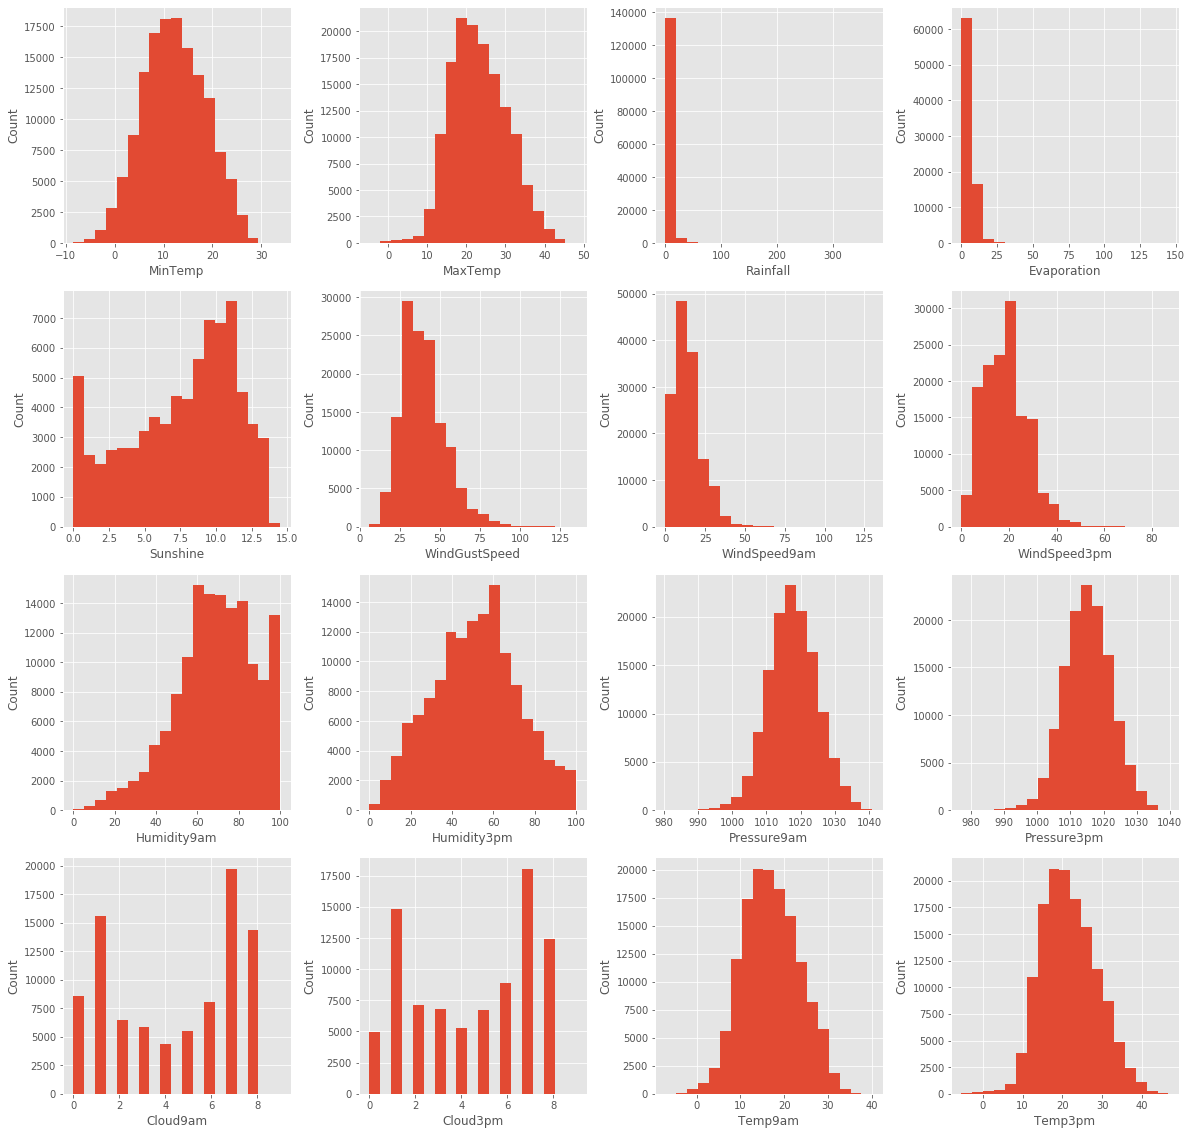

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 20))
for num_index, num in enumerate(num_feature_list):
    sturge_rule = int(np.ceil(1 +  3.322 * np.log10(len(df[num]))))
    plt.subplot(4, 4, num_index +1)
    fig = df[num].hist(bins=sturge_rule)
    fig.set_xlabel(num)
    fig.set_ylabel('Count')
plt.subplots_adjust(wspace=0.3)

We can see that the numerical features follow very different distributions. Most of them are unimodal while __Cloud9am__, __Cloud3pm__, __Humidity9am__ and __Sunshine__ are definitely bimodal. We can also see that almost all have are noticeable skewed, expect the two __Pressure__ features. Furthermore, we can see that the binning for __Rainfall__ and __Evaporation__ suffer from extrem outliners. 

So we certainly should get rid of outliners and we also may need to transform our features (standardize, ...) to improve the handling for our models.

3.4.2 __Missing values__

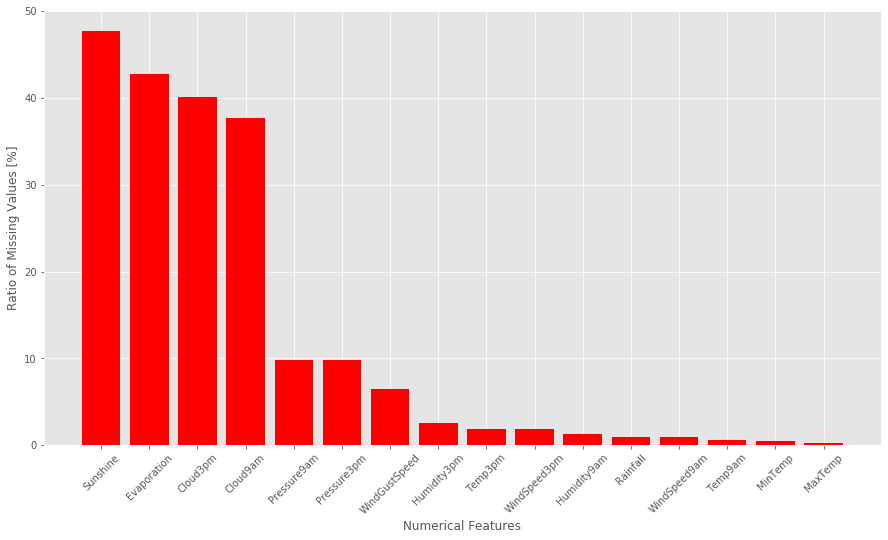


 There are a total of 67816 missing values for the feature 'Sunshine'.

 There are a total of 60843 missing values for the feature 'Evaporation'.

 There are a total of 57094 missing values for the feature 'Cloud3pm'.

 There are a total of 53657 missing values for the feature 'Cloud9am'.

 There are a total of 14014 missing values for the feature 'Pressure9am'.

 There are a total of 13981 missing values for the feature 'Pressure3pm'.

 There are a total of 9270 missing values for the feature 'WindGustSpeed'.

 There are a total of 3610 missing values for the feature 'Humidity3pm'.

 There are a total of 2726 missing values for the feature 'Temp3pm'.

 There are a total of 2630 missing values for the feature 'WindSpeed3pm'.

 There are a total of 1774 missing values for the feature 'Humidity9am'.

 There are a total of 1406 missing values for the feature 'Rainfall'.

 There are a total of 1348 missing values for the feature 'WindSpeed9am'.

 There are a total of 904 missing values fo

In [14]:
num_missing_value_list = [(num, (df[num].isnull().sum()/len(df[num]))*100) for num in num_feature_list]
sorted_list = sorted(num_missing_value_list, key = lambda x: x[1], reverse=True)
num_feature_list_sorted, num_missing_value_list_sorted = zip(*sorted_list)
num_pos_sorted = [i for i, _ in enumerate(num_feature_list_sorted)]

plt.figure(figsize=(15,8))
plt.style.use('ggplot')
plt.bar(num_pos_sorted, num_missing_value_list_sorted, color='red')
plt.xlabel("Numerical Features")
plt.ylabel("Ratio of Missing Values [%]")
plt.xticks(num_pos_sorted, num_feature_list_sorted, rotation=45)
plt.show()

num_summary = [print("\n There are a total of {} missing values for the feature \'{}\'.".format(df[num].isnull().sum(), num)) for num in num_feature_list_sorted]

As we can see we basically have 2 differenct groups of features regarding the number of missing values. These are those who have around $10\,\%$ of missing values or less and those who have more than $\frac{1}{3}$ of missing values. We will need to deal with both of these groups, probably in different ways.

Remember that the entry count is at least $81.350$ for all features. Thus even if the missing values take up $50\,\%$ for a feature, we would still have around $40.000$ entries for that feature. Given that the numerical features are only recorded to up to 1 decimal, we shouldn't have to worry about accuracy due to the statistical uncertainty with that many entries for the most part.

We could also try to fill these missing values using a couple of reconstruction algorithms. 

This problem is dealt with below.

Before we move on, we should check how many entries are left after removing all with missing values.

In [21]:
print("We have a total of {} entries without removing missing values.".format(len(df)))
df_full_clear = df.dropna()
print("We have a total of {} entries after removing all entries with missing values.".format(len(df_full_clear)))

We have a total of 142193 entries without removing missing values.
We have a total of 56420 entries after removing all entries with missing values.


So by dropping all entries with missing values, we would be left with roughly $\frac{1}{3}$ of the original size of the data set. $56.420$ entries may put a limit on the classification algorithms that we would potentially use (remember we have to split into sets!). Thus I think it's worth the effort to try to clean the data set in a different!

3.4.3 __Outliners in Rainfall, Evaporation,  WindGustSpeed, WindSpeed9am and WindSpeed3pm__

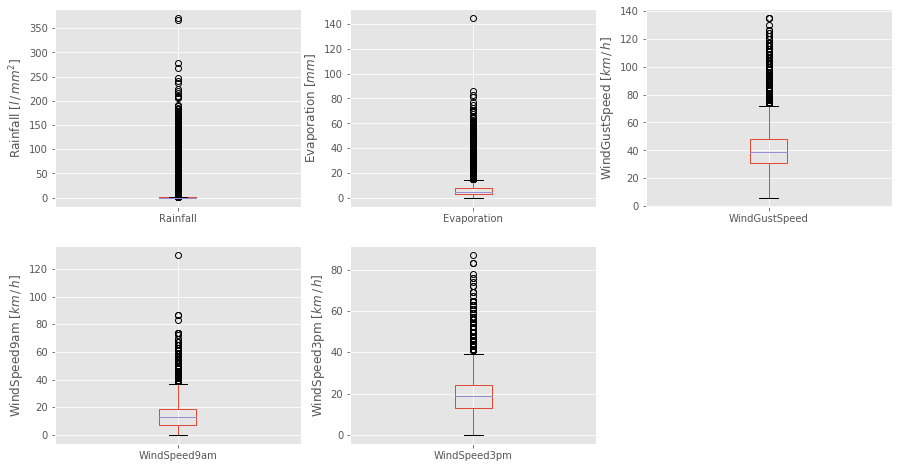

In [16]:
plt.figure(figsize=(15,8))

plt.subplot(2, 3, 1)
fig = df.boxplot(column='Rainfall')
fig.set_ylabel('Rainfall [$l\,/\,mm^2$]')

plt.subplot(2, 3, 2)
fig = df.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation [$mm$]')

plt.subplot(2, 3, 3)
fig = df.boxplot(column='WindGustSpeed')
fig.set_ylabel('WindGustSpeed [$km\,/\,h$]')


plt.subplot(2, 3, 4)
fig = df.boxplot(column='WindSpeed9am')
fig.set_ylabel('WindSpeed9am [$km\,/\,h$]')


plt.subplot(2, 3, 5)
fig = df.boxplot(column='WindSpeed3pm')
fig.set_ylabel('WindSpeed3pm [$km\,/\,h$]')

plt.show()

Undoubtedly we do have some outliners in these features! We will need to deal with them later on.

3.4.4 __Consistency Checks__  

__Temperature Features__

In [17]:
print(df[['MinTemp', 'Temp9am', 'Temp3pm']][(df['MinTemp'] > df['Temp9am']) | (df['MinTemp'] > df['Temp3pm'])])

        MinTemp  Temp9am  Temp3pm
12         15.9     17.4     15.8
100        20.9     22.2     18.8
406        22.6     25.1     19.9
600         7.5      9.3      7.3
765        24.0     24.5     21.2
...         ...      ...      ...
139379     26.0     29.6     25.7
139829     26.7     27.2     24.8
140967     21.4     23.8     17.7
141894     14.2     14.2     14.0
142124     19.3     21.3     18.5

[1188 rows x 3 columns]


Comment: As told above, here we explore the __Mintemp__ and __Maxtemp__ definition.

Here I was looking for the case if __Mintemp__ is higher than either __Temp9am__ or __Temp3pm__. This shouldn't be the case, but as we can clearly see, it is the case for 1188 rows. This seems problematic, so let's have a look again at the publisher:

> The daily (24 hour) maximum and minimum air temperatures are nominally recorded at 9 am local time. The highest temperature for the 24 hours leading up to the observation is recorded as the maximum temperature for the previous day, while the lowest temperature over the previous 24 hours is recorded as the minimum temperature for the day on which the observation was made. If, for some reason, an observation is unable to be made, the next observation is recorded as an accumulation, since there has been more than one day over which the maximum and minimum temperature may have occurred.

http://www.bom.gov.au/climate/cdo/about/about-airtemp-data.shtml



That's actually really helpful. So what we need to do is to compare the three temperature measurements __Temp9am__(day i-1), __Temp3pm__(day i-1) and __Temp9am__(day i) with __Mintemp__ (day i) and __Maxtemp__ (day i-1) as this counts as one day. Though keep in mind that we need to exclude the 9 am measurements for the next day (right?).

In [18]:
df_shifted = df.shift()
MinMaxTemp_check = len(df[(df['MinTemp'] > df_shifted['Temp9am']) |
                       (df['MinTemp'] > df_shifted['Temp3pm']) |
                       (df['MaxTemp'] < df['Temp9am']) |
                       (df['MaxTemp'] < df['Temp3pm'])])
print("Affected row: {}".format(MinMaxTemp_check))

Affected row: 384


Now we can see that this is not a huge problem anymore and only affects 384 rows. Since we are not completly sure which measurement is excluded from the day and which feature we can trust, we can't say for sure how to resolve this problem. But since this only is such a small part of our data, I feel safe ignoring this problem for now.

__Humidity Features__

In [19]:
print(df['Humidity9am'].unique())
print(df['Humidity3pm'].unique())

[ 71.  44.  38.  45.  82.  55.  49.  48.  42.  58.  89.  76.  65.  50.
  69.  80.  47.  56.  54.  41.  78.  46.  43.  33.  34.  36.  52.  51.
  40.  35.  39.  60.  37.  27.  32.  53.  20.  66.  63.  57.  62.  87.
  61.  59.  92.  72.  67.  75.  88.  68.  73.  74.  83.  77.  70.  81.
  86.  97.  99.  91.  85.  93.  84.  94.  79.  98.  96.  95.  90.  64.
  29.  21. 100.  24.  nan  25.  31.  18.  23.  26.  28.  30.  19.  22.
  17.  15.   9.  12.  13.  16.   6.  10.  14.  11.   7.   8.   5.   3.
   2.   4.   0.   1.]
[ 22.  25.  30.  16.  33.  23.  19.   9.  27.  91.  93.  43.  28.  82.
  65.  32.  26.  24.  17.  15.  70.  12.   8.  31.  20.  10.  21.  39.
  13.  11.  69.  18.  14.  35.  90.  68.  74.  41.  34.  78.  49.  37.
  42.  47.  52.  29.  86.  89.  62.  79.  48.  46.  38.  44.  51.  36.
  45.  40.  53.  61.  59.  63.  54.  57.  50.  58.  75.  97.  80.  95.
  56.  72.  60.  71.  73.  81.  76.  64.  87.  85.  67.  55.  77.  84.
   7.  99.  92.  66.  83.  94.  96.  88.  nan 100.  98.

Ignoring the nan values, the humidity features really only recorded integers from 0 to 100.  
As for the other features, the table above given by the describe function is sufficient.

Undoubtedly we do have some outliners in these features! We will need to deal with them later on.